In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
from img_utils import data_to_DF
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)

2024-02-20 12:13:54.166912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[ WARN:0@33.961] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@41.752] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity


In [4]:
from utils import remove_outliers
from img_utils import preprocess_images

#Take only Copenhagen, and Ejerlejligheder
houses_df = houses_df[(houses_df['postal_code'] >= 1000) & (houses_df['postal_code'] <= 2920)]
houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']

#Remove theoutliers 
houses_df = remove_outliers(houses_df, 'price')

#Drop houses with no floorplan
houses_df = houses_df.dropna(subset=['image_floorplan'])

In [5]:
import numpy as np
import pandas as pd
#Set the basement_size to 0 if it is NaN
houses_df['basement_size'] = houses_df['basement_size'].fillna(0)

#Set the year_rebuilt to year_built if it is NaN
houses_df['year_rebuilt'] = houses_df['year_rebuilt'].fillna(houses_df['year_built'])


#Encode the features: postal_code, type, energy_class
houses_df['postal_code'] = houses_df['postal_code'].astype('category').cat.codes
houses_df['type'] = houses_df['type'].astype('category').cat.codes
houses_df['energy_label'] = houses_df['energy_label'].astype('category').cat.codes

#Drop Adress
houses_df = houses_df.drop(columns=['address'])

In [6]:
from sklearn.model_selection import train_test_split

#DROP ANY NAN VALUES
houses_df = houses_df.dropna()

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

# Feeding Vision Prediction into Random Forrest

In [7]:
import joblib
from tensorflow.keras.models import load_model
mobilenet_model = load_model('Trained_models/MobileNet_Continous.keras')

In [8]:
#Insert Vision Predictions into the dataframes
target_width = 224
target_height = 224

resize = True
gray_scale = False
threshhold = True
scale = False

train_df['vision_prediction'] = mobilenet_model.predict(preprocess_images(train_df,'image_floorplan',   target_width, target_height, resize, gray_scale, threshhold))
valid_df['vision_prediction'] = mobilenet_model.predict(preprocess_images(valid_df,'image_floorplan',   target_width, target_height, resize, gray_scale, threshhold))
test_df['vision_prediction'] = mobilenet_model.predict(preprocess_images(test_df,'image_floorplan',   target_width, target_height, resize, gray_scale, threshhold))

x_train = train_df.drop(columns=['image_floorplan', 'price'])
y_train = train_df['price']
x_valid = valid_df.drop(columns=['image_floorplan', 'price'])
y_valid = valid_df['price']
x_test = test_df.drop(columns=['image_floorplan', 'price'])
y_test = test_df['price']

2/2 [==============================] - 2s 637ms/step


Mean Squared Error: 2415463832409.091
Mean Absolute Error: 1115333.6363636365
R2 Score: 0.5225709609898822
Feauture Importance
postal_code 0.1454
type 0.0
size 0.6914
basement_size 0.0
rooms 0.0118
year_built 0.0357
year_rebuilt 0.0329
energy_label 0.0329
vision_prediction 0.0497
R2 score:  0.740176915266467
Mean squared error:  1004484120623.6364
Mean absolute error:  647716.9090909091


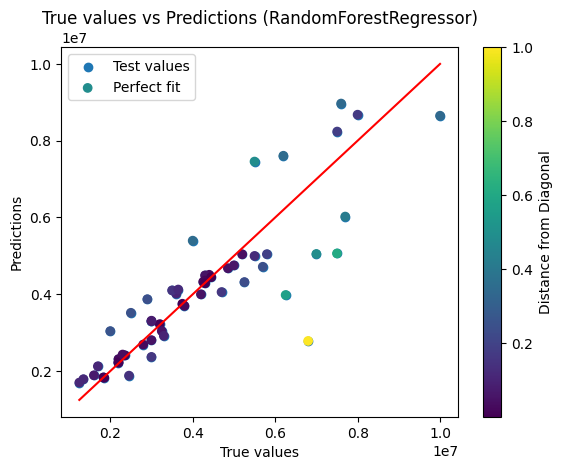

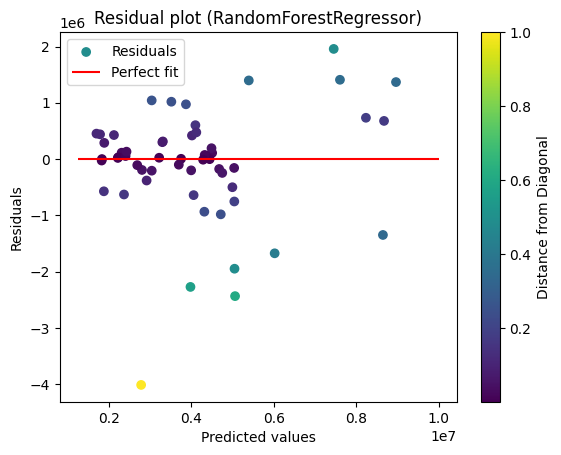

In [10]:
#Create a randmo forest model, that takes in the vision prediction and the features
from sklearn.ensemble import RandomForestRegressor
from utils import plot_regression_results

#Create a random forest model
forest = RandomForestRegressor(random_state=0)
forest.fit(x_train, y_train)

#Evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = forest.predict(x_valid)
print('Mean Squared Error:', mean_squared_error(y_valid, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_valid, y_pred))
print('R2 Score:', r2_score(y_valid, y_pred))


print("Feauture Importance")
for feature, importance in zip(x_train.columns, forest.feature_importances_):
    print((feature), round(importance,4))
print("R2 score: ", forest.score(x_test, y_test))
print("Mean squared error: ", mean_squared_error(y_test, forest.predict(x_test)))
print("Mean absolute error: ", mean_absolute_error(y_test, forest.predict(x_test)))

plot_regression_results(forest.__class__.__name__, y_test, forest.predict(x_test))

# Other things 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Concatenate, concatenate, MaxPooling2D, BatchNormalization, Dropout


     
def create_multi_input_model(feature_model_output, 
                             vision_model_output, 
                             x_train_features,
                             x_train_images,
                             y_train_labels,
                             x_valid_features,
                             x_valid_images,
                             y_valid_labels,
                             ):
  #load the vision model 
  m1 = vision_model_output

  

  # MLP - Should change this to feauture_model_output later 
  m2 = Sequential()
  m2.add(Dense(16, activation='relu', input_dim=x_train_features.shape[1]))
  m2.add(Dense(4, activation='relu'))

  # Combination
  combinedModel = concatenate([m2.output, m1.output])

  # Last layers
  densef1 = Dense(8, activation='relu')(combinedModel)
  densef1 = Dense(4, activation='relu')(combinedModel)
  densef2 = Dense(1, activation='linear')(densef1)
  model = Model(inputs=[m2.input, m1.input], outputs=densef2)

  """
  #Load the vision model 
  # vision_model = vision_model_output
  # vision_model.trainable = False

  # #Define the feature model (NOT LOAD)
  # feature_model = Sequential()
  # feature_model.add(Dense(64, input_dim=x_train_features.shape[1], activation='relu'))
  # feature_model.add(Dense(64, activation='relu'))
  # feature_model.add(Dense(1))

  # #Define the input layers
  # feature_input = Input(shape=(x_train_features.shape[1],))
  # vision_input = Input(shape=(x_train_images.shape[1], x_train_images.shape[2], x_train_images.shape[3]))

  # #Connect the input layers to the models
  # feature_output = feature_model(feature_input)
  # vision_output = vision_model(vision_input)

  # #Combine the output of the models
  # combined = concatenate([feature_output, vision_output])

  # #Add a regression head
  # regression_output = Dense(1)(combined)

  # #Create the model
  # model = Model(inputs=[feature_input, vision_input], outputs=regression_output)
  """

  #Compile the model
  model.compile(optimizer='adam', 
                loss='mean_squared_error',
                metrics=['mean_absolute_percentage_error'])
  
  #Train the model
  history = model.fit([x_train_features, x_train_images], y_train_labels, 
                      validation_data=([x_valid_features, x_valid_images], y_valid_labels),
                      epochs=200, 
                      batch_size=16,
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])
  return model

    
# Create the model
multi_input_model = create_multi_input_model(rf_model, mobilenet_model,
                                              train_features, train_images, train_labels,
                                              valid_features, valid_images, valid_labels)


Epoch 1/200
11/11 [==============================] - 25s 1s/step - loss: 8796789276672.0000 - mean_absolute_percentage_error: 43.2446 - val_loss: 11859315916800.0000 - val_mean_absolute_percentage_error: 46.7863
Epoch 2/200
11/11 [==============================] - 6s 582ms/step - loss: 8084720189440.0000 - mean_absolute_percentage_error: 39.8811 - val_loss: 11065000722432.0000 - val_mean_absolute_percentage_error: 43.8174
Epoch 3/200
11/11 [==============================] - 6s 579ms/step - loss: 7395799465984.0000 - mean_absolute_percentage_error: 37.1875 - val_loss: 10357465677824.0000 - val_mean_absolute_percentage_error: 41.4124
Epoch 4/200
11/11 [==============================] - 6s 549ms/step - loss: 6821516935168.0000 - mean_absolute_percentage_error: 35.0102 - val_loss: 9690703462400.0000 - val_mean_absolute_percentage_error: 39.3895
Epoch 5/200
11/11 [==============================] - 7s 627ms/step - loss: 6285485932544.0000 - mean_absolute_percentage_error: 33.6499 - val_loss:

KeyboardInterrupt: 

In [ ]:
#make 5 predictions 
number = 50
five_predictions =(multi_input_model.predict([valid_features[:number], valid_images[:number]]))
real_prices = np.exp(valid_labels[:number])
for i in range(len(five_predictions)):
  print(f"Predicted price: {five_predictions[i][0]:.2f}, Real price: {real_prices.iloc[i]}")
  

2/2 [==============================] - 2s 412ms/step
Predicted price: -403.17, Real price: 2749999.9999999986
Predicted price: -70.17, Real price: 2794999.9999999995
Predicted price: -282.67, Real price: 6495000.0
Predicted price: 288.26, Real price: 2774999.9999999967
Predicted price: 436.20, Real price: 3795000.0000000014
Predicted price: 170.89, Real price: 2194999.999999998
Predicted price: 345.51, Real price: 5644999.999999998
Predicted price: 1268.89, Real price: 3595000.0000000005
Predicted price: 398.51, Real price: 9995000.000000004
Predicted price: 476.64, Real price: 8995000.000000004
Predicted price: -721.42, Real price: 2994999.9999999995
Predicted price: 290.58, Real price: 5295000.0
Predicted price: 1120.89, Real price: 1995000.0000000002
Predicted price: -146.11, Real price: 4795000.000000001
Predicted price: -566.17, Real price: 4995000.000000002
Predicted price: 223.83, Real price: 3695000.000000002
Predicted price: 21.51, Real price: 8995000.000000004
Predicted price

In [ ]:
from utils import 